## Example: Eigenfaces for feature extraction

Another application of PCA that we mentioned earlier is feature extraction. The idea behind feature extraction is that it is possible to find a representation of your data that is better suited to analysis than the raw representation you were given. A great example of an application where feature extraction is helpful is with images. Images are made up of pixels, usually stored as red, green, and blue (RGB) intensities. Objects in images are usually made up of thousands of pixels, and only together are
they meaningful.

We will give a very simple application of feature extraction on images using PCA, by working with face images from the **Labeled Faces in the Wild (LFW)** dataset. This dataset contains face images of celebrities downloaded from the Internet, and it includes
faces of politicians, singers, actors, and athletes from the early 2000s. We use grayscale versions of these images, and scale them down for faster processing.

In [1]:
#Todo: import lfw dataset from sklearn datasets
from sklearn.datasets import fetch_lfw_people

people = fetch_lfw_people(min_faces_per_person=20,resize=0.7, data_home='faces')
image_shape = people.images[0].shape
#Todo: analyze the dataset with the people faces.. use as many code cells as needed

#Todo: Plot the images of people target and images

There are 3,023 images, each 87×65 pixels large, belonging to 62 different people

In [2]:
#Todo: print number of classes, people.image.shape and people.data.shape
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

fig, axes = plt.subplots(2,5,figsize=(10,5),subplot_kw={'xticks':(), 'yticks':()})

for target,image, ax in zip(people.target, people.images, axes.ravel()):
    ax.imshow(image)
    ax.set_title(people.target_names[target])

print ('Number of people: {}', format(people.images.shape[0]))
print ('Number of classes: {}', format(len(people.target_names)))
print ('Data Shape: {}', format(people.data.shape))

Number of people: {} 3023
Number of classes: {} 62
Data Shape: {} (3023, 5655)


The dataset is a bit skewed, however, containing a lot of images of George W. Bush and Colin Powell, as you can see here:

In [3]:
#Todo: count how often each target appears. Assign to variable counts
counts = np.bincount(people.target)
##Todo: print counts next to target names
for i, (count,name) in enumerate(zip(counts,people.target_names)):
    print ("{0:17}{1:3}".format(name,count),end='')
    if(i+1)%3==0:
        print()

Alejandro Toledo  39Alvaro Uribe      35Amelie Mauresmo   21
Andre Agassi      36Angelina Jolie    20Ariel Sharon      77
Arnold Schwarzenegger 42Atal Bihari Vajpayee 24Bill Clinton      29
Carlos Menem      21Colin Powell     236David Beckham     31
Donald Rumsfeld  121George Robertson  22George W Bush    530
Gerhard Schroeder109Gloria Macapagal Arroyo 44Gray Davis        26
Guillermo Coria   30Hamid Karzai      22Hans Blix         39
Hugo Chavez       71Igor Ivanov       20Jack Straw        28
Jacques Chirac    52Jean Chretien     55Jennifer Aniston  21
Jennifer Capriati 42Jennifer Lopez    21Jeremy Greenstock 24
Jiang Zemin       20John Ashcroft     53John Negroponte   31
Jose Maria Aznar  23Juan Carlos Ferrero 28Junichiro Koizumi 60
Kofi Annan        32Laura Bush        41Lindsay Davenport 22
Lleyton Hewitt    41Luiz Inacio Lula da Silva 48Mahmoud Abbas     29
Megawati Sukarnoputri 33Michael Bloomberg 20Naomi Watts       22
Nestor Kirchner   37Paul Bremer       20Pete Sampras      

To make the data less skewed, we will only take up to 50 images of each person (otherwise, feature extraction would be overwhelmed by the likelihood of "George W Bush".

In [4]:
mask = np.zeros(people.target.shape, dtype=np.bool)

#Todo: take only 50 features per person
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]]=1
X_people = people.data[mask]
y_people = people.target[mask]

#Todo:  scale the grayscale values to be between 0 and 1 instead of 0 and 255 for better numeric stability
# and assign it to X_people
X_people = X_people/225
X_people.shape

(2063, 5655)

A common task in face recognition is to ask if a previously unseen face belongs to a known person from a database. This has applications in photo collection, social media, and security applications. One way to solve this problem would be to build a
classifier where each person is a separate class. However, there are usually many different people in face databases, and very few images of the same person (i.e., very few training examples per class). That makes it hard to train most classifiers. Additionally, you often want to be able to add new people easily, without needing to retrain a large model.

A simple solution is to use a one-nearest-neighbor classifier that looks for the most similar face image to the face you are classifying. This classifier could in principle work with only a single training example per class. Let’s take a look at how well `KNeighborsClassifier` does here:

In [5]:
#Todo: import KNN and train test split from sklearn

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

#Todo: split the data into training and test sets
X_train, X_test, y_train, y_test =train_test_split(X_people, y_people, stratify=y_people, random_state=0)

#Todo: build a KNeighborsClassifier using one neighbor
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train,y_train)
#Todo: print the test score
print('Test set score of 1-nn:{:.2f}'.format(knn.score(X_test,y_test)))

Test set score of 1-nn:0.23


We obtain an accuracy of 26.6%, which is not actually that bad for a 62-class classification problem (random guessing would give you around 1/62 = 1.5% accuracy), but is also not great. We only correctly identify a person every fourth time.

This is where PCA comes in. Computing distances in the original pixel space is quite
a bad way to measure similarity between faces. When using a pixel representation to
compare two images, we compare the grayscale value of each individual pixel to the
value of the pixel in the corresponding position in the other image. This representation
is quite different from how humans would interpret the image of a face, and it is
hard to capture the facial features using this raw representation. For example, using
pixel distances means that shifting a face by one pixel to the right corresponds to a
drastic change, with a completely different representation. We hope that using distances
along principal components can improve our accuracy. 

Here, we enable the *whitening* option of PCA, which rescales the principal components to have the same
scale. This is the same as using `StandardScaler` but after the transformation. Whitening corresponds to not only rotating the data, but also rescaling it so that the center panel is a circle instead of an ellipse:

In [6]:
#Todo: PCA and whiten feature of PCA to fit and train the Xtrain data
from sklearn.decomposition import PCA

pca = PCA(n_components=100, whiten=True, random_state=0).fit(X_train)
X_train_pca =pca.transform(X_train)
X_test_pca = pca.transform(X_test)

#check the size
print("X_train_pca.shape: {}".format(X_train_pca.shape))
print("X_train_pca.shape: {}".format(X_test_pca.shape))

X_train_pca.shape: (1547, 100)
X_train_pca.shape: (516, 100)


In [7]:
pca.components_.shape

(100, 5655)

The new data has 100 features, the first 100 principal components. Now, we can use
the new representation to classify our images using a one-nearest-neighbors classifier:

In [8]:
#Todo: use KNN to refit the PCA fitted data
knn =KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_pca, y_train)
print('Test set accuracy: {:.2f}'.format(knn.score(X_test_pca,y_test)))

Test set accuracy: 0.31


Our accuracy should improve, thus confirming our intuition that the principal components might provide a better representation of the data.

For image data, we can also easily visualize the principal components that are found.
Remember that components correspond to directions in the input space. The input
space here is 50×37-pixel grayscale images, so directions within this space are also
50×37-pixel grayscale images.

Let's look at the first couple of principal components

In [9]:
#Todo: print the pca components and shape
print('PCA components and shape: {}'.format(pca.components_.shape))

PCA components and shape: (100, 5655)


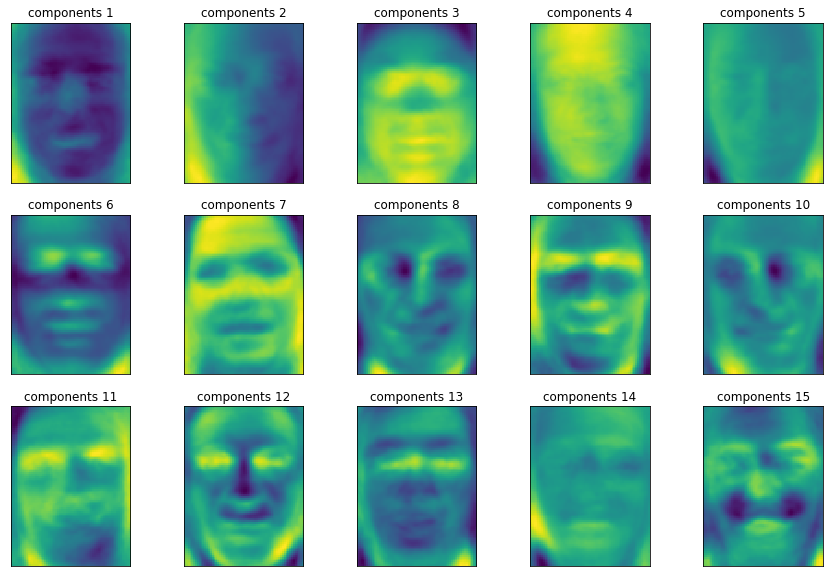

In [10]:
#Todo: plot the components
fix, axes = plt.subplots(3,5, figsize=(15,10),
                        subplot_kw={'xticks':(), 'yticks':()})
for i, (component, ax) in enumerate(zip(pca.components_,axes.ravel())):
    ax.imshow(component.reshape(image_shape),
             cmap='viridis')
    ax.set_title("components {}".format((i+1)))

While we certainly cannot understand all aspects of these components, we can guess which aspects of the face images some of the components are capturing. 

The first component seems to mostly encode the contrast between the face and the background, the second component encodes differences in lighting between the right and the left half of the face, and so on. While this representation is slightly more semantic than the raw pixel values, it is still quite far from how a human might perceive a face.

As the PCA model is based on pixels, the alignment of the face (the position of eyes, chin, and nose) and the lighting both have a strong influence on how similar two images are in their pixel representation. But alignment and lighting are probably not
what a human would perceive first. When asking people to rate similarity of faces, they are more likely to use attributes like age, gender, facial expression, and hair style, which are attributes that are hard to infer from the pixel intensities. It’s important to keep in mind that algorithms often interpret data (particularly visual data, such as images, which humans are very familiar with) quite differently from how a human would.

Let's come back to the specific case of PCA, though. We introduced the PCA transformation as rotating the data and then dropping the components with low variance. Another useful interpretation is that PCA tries to find some numbers (the new feature values
after the PCA rotation) so that we can express the test points as a weighted sum of the principal components.

![](resources/pca-faces.png)

Here, $x_0$, $x_1$, and so on are the coefficients of the principal components for this data
point; in other words, they are the representation of the image in the rotated space.

Another way we can try to understand what a PCA model is doing is by looking at the reconstructions of the original data using only some components. In the earlier simple example (of random data in 2 dimensions): After dropping the second component, we undid the rotation and added the mean back to obtain data points in the original space with the second component removed. We can do something similar here by reducing the data to only some principal components and then rotating back to the original feature space. Similarly, this return to original feature space can be achieved easily using `inverse_transform()` method. Let's visualize the reconstruction of some faces using 10, 50, 100, 500 components.

In [11]:
#Todo: write a function to do all the reconstruction
def reconstruct_pca_faces(X_train, X_test):
    #Todo: create a list to hold all the inverse transformed (reconstructed) faces
    reduced_images = []
    #Todo: continue coding
    for n_component in [10,50,100,500,2000]:    
        pca = PCA (n_components = n_component)
        pca.fit(X_train)
    
        X_test_pca = pca.transform(X_test)
    
        X_test_inverse = pca.inverse_transform(X_test_pca)
        reduced_images.append(X_test_inverse)
    return reduced_images

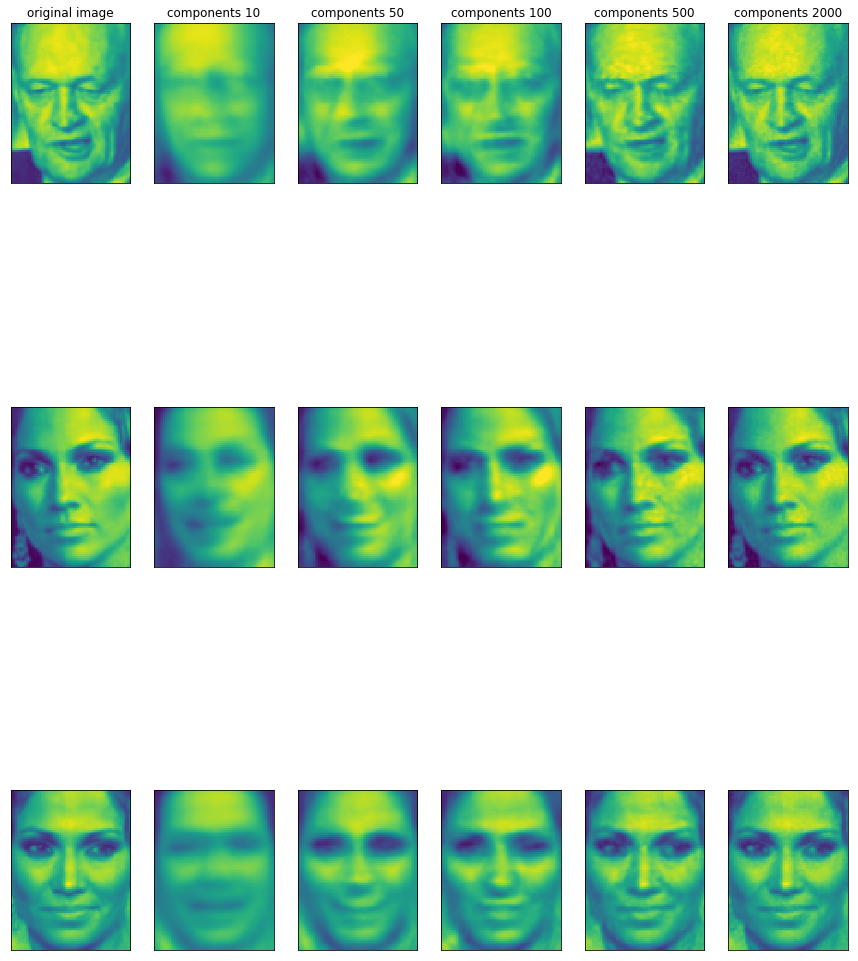

In [12]:
#Todo:  plot the first three images in the test set:
scaled_images = reconstruct_pca_faces(X_train, X_test)

fig, axes = plt.subplots(3,6, figsize = (15,20),
                        subplot_kw = {'xticks':(), 'yticks': ()})

for i, ax in enumerate (axes):
    #plot original image
    ax[0].imshow(X_test[i].reshape(image_shape), vmin=0, vmax=1)
    #plot the four back-transformed images
    for a,X_test_inverse in zip (ax[1:], scaled_images):
        a.imshow(X_test_inverse[i].reshape(image_shape), vmin=0, vmax=1)
        
#label the top row
axes[0,0].set_title('original image')
for ax, n_component in zip(axes[0,1:], [10,50,100, 500, 2000]):
    ax.set_title('components {}'.format((n_component)))
    
plt.show()        

You can see that when we use only the first 10 principal components, only the essence
of the picture, like the face orientation and lighting, is captured. By using more and
more principal components, more and more details in the image are preserved. This corresponds to extending the "sum of components" we saw earlier to include more and more terms. Using as many components as there are pixels would mean that we would not discard any information after the rotation, and we would reconstruct the image perfectly.

We can also try to use PCA to visualize all the faces in the dataset in a scatter plot using the first two principal components, with classes given by who is shown in the image, similarly to what we did for the cancer dataset:

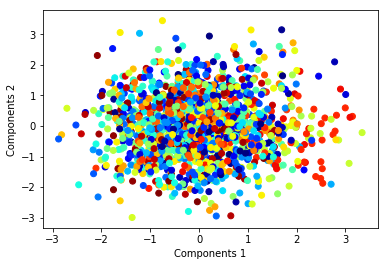

In [13]:
#Todo: plot the first and second principle components in a scatter plot
plt.scatter(X_train_pca[:,0],X_train_pca[:,1],c=y_train,cmap='jet')
plt.xlabel('Components 1')
plt.ylabel('Components 2')
plt.show()

Oh well. As you can see, when we use only the first two principal components the whole data
is just a big blob, with no separation of classes visible. This is not very surprising,
given that even with 10 components, PCA only captures very rough characteristics of the faces.